# Libraries and Settings

#### Libraries

In [1]:
##########==========##########==========##########==========##########==========

## general purpose libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import urllib.request    as url

from datetime          import datetime, timedelta
from bs4               import BeautifulSoup
from os                import listdir, mkdir
from os.path           import isdir, isfile
from geopy.distance    import distance
from docx              import Document
from textwrap          import TextWrapper
from matplotlib.dates  import DateFormatter
from matplotlib.colors import hsv_to_rgb, to_hex


## time stamp functions
set_timing = dict()
def time_check(id_str = 'ZZ'):
    raw_time = datetime.now()
    current_time = [raw_time.hour, raw_time.minute, round(raw_time.second)]
    current_time = [str(i).zfill(2) for i in current_time]
    current_time = ':'.join(current_time)
    current_time = 'Time Check ' + id_str.ljust(4) + ' = ' + current_time
    set_timing[id_str] = current_time
    if id_str == 'ZZ':
        for i in set_timing:
            print(set_timing[i])

time_check('AA')

#### Settings

In [2]:
## url source of the data
set_url = "https://www.ncei.noaa.gov/data/local-climatological-data/access/{0}/"
set_year = range(2012, 2022)
set_prefix = ['69', '70', '72', '74', '91', '99']#.append('71') # 71 = Canada

## cache settings
set_cache = {'hard_reset':     False,
             'station_roster': True,  # wired
             'collection':     True,  # wired
             'compilation':    True, # wired
             'modeling':       False}

## defines dtype for the columns in the raw weather data files
set_col_list = {'DATE':str, 'LATITUDE':float,
    'LONGITUDE':float, #'ELEVATION':float,
    "HourlyDryBulbTemperature":float,
    "HourlyPrecipitation":float}

## set modeling and display parameters
set_param = {'home_city': 'Washington DC'}

set_color = [1/12, 4/12, 7/12, 10/12]
set_color = [hsv_to_rgb((i, 0.7, 0.7)) for i in set_color]
set_color = [
    (7/12, 0.7, 0.7), (1/12, 0.5, 0.9), (1/12, 0.7, 0.7), (7/12, 0.5, 0.9)]
set_color = [to_hex(hsv_to_rgb(i)) for i in set_color]

#### set up file system (if needed)

In [3]:
## make directories that script expects
def make_directories():
    all_dirs = ['A_Input', 'B_Process', 'C_Output']
    all_dirs = all_dirs + ['B_Process/downloads']
    for i in all_dirs:
        if not isdir(i): mkdir(i)
        
make_directories()

# Import Data

#### retrieve city roster file and text explanation files

In [4]:
## read/format project explanation docx
def read_explainer(address = 'A_Input/explanation.docx', txt_len = 50):
    
    ## read in file
    doc = Document(address).paragraphs
    doc = [i.text for i in doc]
    doc = ' '.join(doc)
    
    ## wrap text
    tw = TextWrapper(width = txt_len, 
                     replace_whitespace = False, fix_sentence_endings = True,
                     break_long_words = False, drop_whitespace = False)
    doc = tw.fill(doc)
    doc = doc.format('\n\n')
    return doc
    
## execute functions
city_roster = pd.read_excel('A_Input/city_list.xlsx',
    usecols = {'City': str, 'Route': str, 'lon': float, 'lat': float})
project_explainer = read_explainer()

#### retrieve links page for first year

In [5]:
def make_data_roster(the_year, the_url = set_url, valid_prefix = set_prefix):
  
    ## retrive raw web page
    the_url = the_url.format(the_year)
    with url.urlopen(the_url) as conn:
        all_files = conn.read()
        conn.close()
        
    ## extract links to csv files
    all_files = BeautifulSoup(all_files)
    all_files = all_files.find_all('a')
    all_files = [i.string for i in all_files if i.string.find('.csv') != -1]
        
    ## package as pandas files; limit to valid prefix
    all_files = pd.DataFrame({'prefix':0, 'file':all_files,
        'lon': np.nan, 'lat': np.nan, 'dist': np.nan, 'city': 'Unknown'})
    all_files['prefix'] = [i[0:2] for i in all_files['file']]
    all_files = all_files[all_files.prefix.isin(valid_prefix)]
    all_files = all_files.reset_index()

    del all_files['index']
    
    return all_files 

## execute code
data_roster = make_data_roster(set_year[-1])

#### determine which stations are near route cities

In [6]:
def read_station_data(x, ucl = set_col_list):
    the_csv = pd.read_csv(x, usecols = ucl, parse_dates = ['DATE'], dtype = str)
    for j in ucl.keys():
        if ucl[j] == float:
            the_csv[j] = pd.to_numeric(the_csv[j], errors = 'coerce')
    the_csv.LATITUDE = the_csv.LATITUDE.fillna(0)
    the_csv.LONGITUDE = the_csv.LONGITUDE.fillna(0)
    return the_csv

def filter_to_proximate_data(
    dat_rost = data_roster, the_url = set_url, city = city_roster):

    print('Evaluating:', end = ' ')
    for i in dat_rost.index:
        ## print(dat_rost.loc[i, 'file'], end=', ')
        
        ## download file and coerce numeric columns to numeric
        full_url = set_url.format(set_year[-1]) + dat_rost.loc[i, 'file']
        the_csv = read_station_data(full_url)

        ## find distance to closest rostered metro area
        min_dist = 999999
        prox_city = None
        for j in city.index:
            dist_j = distance(
                tuple(the_csv.loc[0, ['LATITUDE', 'LONGITUDE']]),
                tuple(city.loc[j, ['lat', 'lon']])).miles
            if dist_j < min_dist:
                min_dist = dist_j
                prox_city = city.loc[j, 'City']
        dat_rost.loc[i, 'dist'] = np.round(min_dist)
        dat_rost.loc[i, 'city'] = prox_city
        
    ## save roster file to disk
    dat_rost.to_csv('B_Process/station_roster.csv')
    return dat_rost

def cache_or_make_csv(address, cache_bool, function):
    if not cache_bool or not isfile(address):
        print('Cache or make: Making file')
        x = function()
    else:
        print('Cache or make: Retrieving cache')
        x = pd.read_csv(address)
    return x

## execution functions
station_roster = cache_or_make_csv(
    address = 'B_Process/station_roster.csv',
    cache_bool = set_cache['station_roster'],
    function = filter_to_proximate_data
)

Cache or make: Retrieving cache


#### retrieve data from subsequent years for proximate stations

In [7]:
def retrieve_station_data(
    roster = station_roster, url = set_url, year = set_year, ucl = set_col_list):
    
    ## download all relavent data files
    for i in year:
        if not str(i) in roster.columns: roster[str(i)] = False
        needed_file = (roster.dist < 30) & ~roster[str(i)]
        for j in roster.index[needed_file]:
            ## download data file
            try:
                error_flag = False
                x = read_station_data(url.format(i) + roster.loc[j, 'file'])
                if i == year[0]:
                    roster.loc[j, 'lon'] = x.loc[0, 'LONGITUDE']
                    roster.loc[j, 'lat'] = x.loc[0, 'LATITUDE']
                x.to_csv(
                    'B_Process/downloads/' + str(i) + '_' +
                    roster.loc[j, 'file'] + '.gz')
            except:
                error_flag = True
            
            ## update roster
            if error_flag: roster.loc[j, str(i)] = False
            else: roster.loc[j, str(i)] = True
            roster.to_csv('B_Process/station_roster.csv')

## execution functions
if not set_cache['collection']: retrieve_station_data()
print('TODO: Evaluate whether to build an override that forces new download')

TODO: Evaluate whether to build an override that forces new download


#### record completion time stamp

In [8]:
time_check('ID')

# Refine Data

#### Refine and combine files

In [9]:
def compile_weather_data(address = 'B_Process/downloads', ucl = set_col_list):
    
    ## make list of all available data files
    file_list = listdir(address)
    file_list = filter(lambda x: x[-7::] == '.csv.gz', file_list)
    
    ## read in the data
    weather_data = []
    for i in file_list:
        
        ## read in file
        x = read_station_data('B_Process/downloads/' + i)
        x['source'] = i
        
        ## unpack date information
        x['hour'] = x.DATE.dt.hour
        x['day'] = x.DATE.dt.dayofyear
        x = x.drop('DATE', axis = 1)
        x = x.loc[x.day != 366, ]
        
        ## score weather
        for i in ['HourlyPrecipitation', 'HourlyDryBulbTemperature']:
            x[i] = x[i].fillna(0)
        x['score'] = (x['HourlyDryBulbTemperature'] <= 75) &\
            (x['HourlyDryBulbTemperature'] >= 55) &\
            (x['HourlyPrecipitation'] <= 0.2)
        x['score'] = x['score'].astype(int)
        x = x.drop(['HourlyDryBulbTemperature', 'HourlyPrecipitation'], axis = 1)
        
        ## add refined file to data list
        weather_data.append(x)
        
    ## compile as dataframe and save to disk
    weather_data = pd.concat(weather_data, axis = 0)
    weather_data.to_csv('B_Process/weather_data.csv.gz')
    
    return weather_data

## execute function
weather_data = cache_or_make_csv(
    address = 'B_Process/weather_data.csv.gz',
    cache_bool = set_cache['compilation'],
    function = compile_weather_data
    )

Cache or make: Retrieving cache


In [10]:
time_check('RD')

# Model Routes

#### summarize weather score for each city and then for each route

In [11]:
## score average temperateness of weather for each city
def summarize_by_city(wd = weather_data, sr = station_roster):
    
    ## assign stations to closest metropolitan area
    wd['index'] = [i[5:-3] for i in wd.source]
    wd = wd.set_index('index')
    sr = sr.set_index('file')
    wd = wd.join(sr[['city']])
    
    ## calculate average weather scores
    wd = wd[['city', 'day', 'hour', 'score']]
    wd = wd.groupby(['city', 'day', 'hour']).mean().reset_index()
    wd['score'] = wd['score'].round(6)
    
    wd.to_csv('B_Process/city_score.csv')
    return wd

## calculate average temperateness score across cities in each route
def summarize_by_route(cs, cr = city_roster):
    
    ## merge route assignments
    cs = cs.set_index('city')
    cr = cr.set_index('City')
    cs = cs.join(cr[['Route']])
    
    ## average scores by route
    cs = cs.groupby(['Route', 'day', 'hour']).mean().reset_index()
    cs['score'] = cs['score'].round(6)
    cs.to_csv('B_Process/route_score.csv')
    return cs

## add dc to route scores
def add_home_city(rs, cs, hc):
    hc = cs.loc[cs.city == hc, ]
    hc.columns = rs.columns
    rs = pd.concat([rs, hc], axis = 0)
    return rs

## execute code
city_score  = summarize_by_city()
route_score = summarize_by_route(cs = city_score)
route_score = add_home_city(route_score, city_score, set_param['home_city'])

#### calculate daily summary scores (temperate hours and best time per day)

In [12]:
## sum hours of good weather per day
def sum_temperate_by_day(rs = route_score):
    
    ## sum number of temperate hours by day
    rs = rs.loc[(rs.hour > 6) & (rs.hour < 20), ]
    hour_sum = rs.drop('hour', axis = 1).groupby(['Route', 'day']).sum()
    hour_sum = hour_sum.round().astype(int).reset_index()
    
    return hour_sum

## calculate best travel months
def median_temperate_by_month(ds):
    
    ## convert day of the year into month
    ds['month'] = datetime.fromisoformat('2000-01-01')
    for i in ds.index:
        ds.loc[i, 'month'] = ds.loc[i, 'month'] +\
            timedelta(days = int(ds.loc[i, 'day']))
        ds.loc[i, 'month'] = ds.loc[i, 'month'].month
        
    ## sum hours by month and reshape
    ds = ds.groupby(['Route','month']).median().drop('day', axis = 1)
    ds = ds.reset_index().pivot(
        index = 'Route', columns = 'month', values = 'score').astype(int)
    
    ## categorize routes on a summer to winter scale
    route_weather = np.round(np.array(ds) / 12, 1)
    winter_score = np.ones(route_weather.shape) * np.abs(np.arange(1, 13) - 7)
    winter_score = winter_score + 1
    route_class = (route_weather * winter_score).sum(axis = 1)
    route_class = route_class / route_weather.sum(axis = 1)
    ds['weather_class'] = np.round(route_class, 1)
    ds = ds.sort_values('weather_class')
    ds['weather_class'] = np.arange(0, ds.shape[0]) / (ds.shape[0] / 4)
    ds['weather_class'] = ds['weather_class'].astype(int)
    
    return ds

## execute code
day_score = sum_temperate_by_day()
month_score = median_temperate_by_month(day_score.copy())

In [13]:
#time_check('MR')

# Render Visualization

#### unpack data into suitable format for visualization

In [23]:
def wrap_around_rolling(x, w = 30):
    y = pd.concat([x[len(x) - w + 1::], x]).rolling(w, center = True)
    return y.mean().dropna()

def unpack_data(ds = day_score):
    
    ## unpack routes to separate list objects
    unpacked = dict()
    for i in set(ds.Route):
        unpacked_iter = ds.loc[ds.Route == i, :].copy()
        
        ## calculate 30 moving average of scores for visualization purposes
        unpacked_iter['mov_av'] = wrap_around_rolling(unpacked_iter.score)
        
        ## calculate dates and adjust by 15 days (so date is the center of M.A.)
        f = lambda x: datetime.fromisoformat('2001-01-01') + timedelta(days = x)
        unpacked_iter['date'] = unpacked_iter['day'].apply(f)
        
        ## append route data to object
        unpacked[i] = unpacked_iter.sort_values('date')
    
    return unpacked

visual_data = unpack_data()

#### Set up plot infrastructure

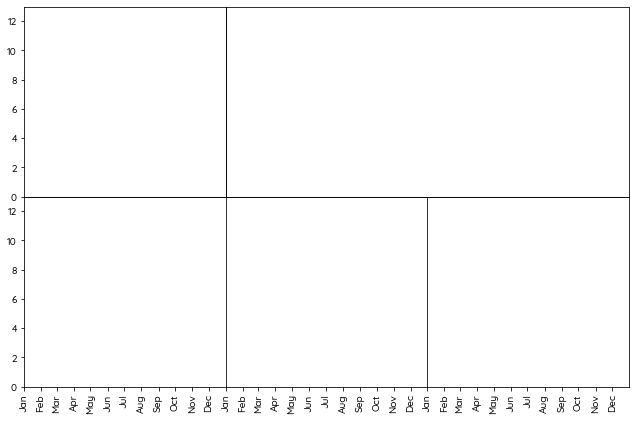

In [24]:
def make_layout():
    
    ## set font
    plt.rcParams['font.sans-serif'] = ['Quicksand']
    
    ## make figure
    dash_figure = plt.figure(figsize = (9, 6))
    dash_grid = dash_figure.add_gridspec(2, 3, figure = dash_figure,
        hspace = 0, wspace = 0,
        bottom = 0.07, top = 1 - 0.05,
        left = 0.05 * (6/9),  right = 1 - 0.05 * (6/9)
        )
    dash_figure.set_facecolor('white')
    
    ## make axes
    dash_axis = dict()
    dash_axis['2']   = dash_figure.add_subplot(dash_grid[1, 0])
    dash_axis['1']   = dash_figure.add_subplot(dash_grid[1, 1])
    dash_axis['0']   = dash_figure.add_subplot(dash_grid[1, 2])
    dash_axis['mat'] = dash_figure.add_subplot(dash_grid[0, 1:3])
    dash_axis['3']   = dash_figure.add_subplot(dash_grid[0, 0])
    
    ## all figures
    for i in dash_axis.keys():
        dash_axis[i].set_facecolor('white')
        dash_axis[i].tick_params(left = False, bottom = False,
            labelleft = False, labelbottom = False,
            top = False, labeltop = False,
            right = False, labelright = False
                                )
        
    ## set x axis
    for i in ['0', '1', '2']:
        dash_axis[i].tick_params(labelbottom = True, bottom = True)
        
    ## set y axis
    for i in ['2', '3']:
        dash_axis[i].tick_params(labelleft = True, left = True)
        
    ## weather line plots
    date_format = DateFormatter('%b')
    for i in range(0, 4):
        dash_axis[str(i)].set_xlim(datetime.fromisoformat('2001-01-01'),
            datetime.fromisoformat('2001-12-31'))
        dash_axis[str(i)].set_ylim(0, 13)
        dash_axis[str(i)].xaxis.set_major_formatter(date_format)
        dash_axis[str(i)].tick_params(axis='x', labelrotation = 90)

    return dash_figure, dash_axis
    
##
dash_figure, dash_axis = make_layout()

#### route score panels

In [25]:
def render_weather_lines(ms = month_score, vd = visual_data):

    color_iter = 0
    for i in range(0, 4):
        
        ## draw month guides
        x = ['2001-03-01', '2001-06-01', '2001-09-01', '2001-12-01']
        x = [datetime.fromisoformat(i) for i in x]
        dash_axis[str(i)].vlines(x = x, ymin = 0, ymax = 13, color = '#F0F0F0')
        dash_axis[str(i)].hlines(y = [4, 8], color = '#F0F0F0',
            xmin = datetime.fromisoformat('2001-01-01'),
            xmax = datetime.fromisoformat('2001-12-31')
            )
        
        ## generate short labels
        short_labels = dict()
        for k in set(ms.index):
            if len(k) > 8:
                short_labels[k] = k[0:8].rstrip() + '.'
            else:
                short_labels[k] = k
        
        ## draw weather score lines
        for j in ms.index[ms.weather_class == i]:
            dash_axis[str(i)].plot(vd[j].date, vd[j].mov_av,
                label = short_labels[j], color = set_color[color_iter])
            color_iter = (color_iter + 1) % len(set_color)
            
            dash_axis[str(i)].legend(loc = 'upper center', ncol = 2,
                labelspacing = 0, borderpad = 0.1, borderaxespad = 0.2)

render_weather_lines()

#### matrix panel

In [26]:
def render_hours_table(ms):
    
    ## convert table to matplotlib's table format
    ms = ms.drop(['weather_class'], axis = 1)
    ms_list = [list(ms.loc[i, ]) for i in ms.index] 
    
    ## generate cell colors
    ms_color = ms
    ms_color = (ms_color / 4).astype(int).replace({
        0: to_hex(hsv_to_rgb((7/12, 0.0, 1.0))),
        1: to_hex(hsv_to_rgb((7/12, 0.2, 0.9))),
        2: to_hex(hsv_to_rgb((7/12, 0.4, 0.8)))
    })
    ms_color = [list(ms_color.loc[i, ]) for i in ms_color.index]
    
    ## assemble table
    dash_axis['mat'].set_xlim(0, 6)
    dash_axis['mat'].set_ylim(0, 3)
    access_object = dash_axis['mat'].table(
        cellText = ms_list,
        cellColours = ms_color, cellLoc = 'center', 
        rowLabels = ms.index, rowLoc = 'right',
        colLabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
                    'Sep', 'Oct', 'Nov', 'Dec'],
        colLoc = 'center',
        loc = 'center',
        bbox = [0.25, 0.0, 0.77, 0.90]
        )
    for i, j in access_object.get_celld().items():
        j.set_linewidth(0)
    access_object.auto_set_font_size(False)
    access_object.set_fontsize(9)
    
    ## add table
    dash_axis['mat'].text(
        x = 6 - 0.02, y = 3 - 0.02,
        s = 'Average Hours of Temperate Weather On Each Travel Route',
        horizontalalignment = 'right', verticalalignment = 'top',
        fontsize = 12
    )

render_hours_table(month_score)

#### save figure to disk

In [27]:
dash_figure.savefig('C_Output/travel_weather.pdf')

In [28]:
time_check('RV')

# Test Code

In [29]:
time_check('TC')

# Miscellaneous

In [30]:
## Display time statistics
time_check('ZZ')

Time Check AA   = 13:57:43
Time Check ID   = 13:57:50
Time Check RD   = 13:58:13
Time Check RV   = 14:05:23
Time Check TC   = 14:05:23
Time Check ZZ   = 14:05:23
